# Exploratory Data Analysis

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
# Gestion de l'affichage (directment dans le notebook)
sns.set_style('whitegrid')
%matplotlib inline

In [71]:
# Cargement du dataset initial
df = pd.read_csv('../data/data.csv')

## Etude globale du dataset

In [72]:
# Informations générales du le dataset initial
print("------ Dimensions du dataset -----\n")
print(f"Lignes: {df.shape[0]}, Colonnes: {df.shape[1]}")

print("\n------ Informations générales et types de données ------\n")
df.info()

print("\n------ Aperçu des premières lignes ------\n")
print(df.head())

print("\n------ Statistiques descriptives pour les variables numériques ------\n")
print(df.describe().T)

------ Dimensions du dataset -----

Lignes: 67352, Colonnes: 32

------ Informations générales et types de données ------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67352 entries, 0 to 67351
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  67352 non-null  object 
 1   NUMBER_OF_REQUESTS  67352 non-null  int64  
 2   TOTAL_DURATION      67352 non-null  int64  
 3   AVERAGE_TIME        67352 non-null  float64
 4   STANDARD_DEVIATION  52945 non-null  float64
 5   REPEATED_REQUESTS   67352 non-null  float64
 6   HTTP_RESPONSE_2XX   67352 non-null  float64
 7   HTTP_RESPONSE_3XX   67352 non-null  float64
 8   HTTP_RESPONSE_4XX   67352 non-null  float64
 9   HTTP_RESPONSE_5XX   67352 non-null  float64
 10  GET_METHOD          67352 non-null  float64
 11  POST_METHOD         67352 non-null  float64
 12  HEAD_METHOD         67352 non-null  float64
 13  OTHER_METHOD        67352 no

Distribution des classes:
ROBOT
0    79.96496
1    20.03504
Name: proportion, dtype: float64


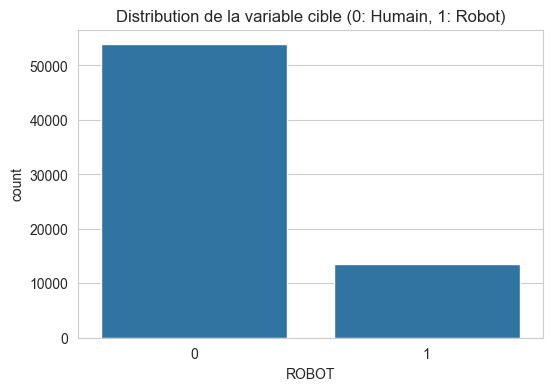

In [73]:
# Etude de l'équilibre des classes
plt.figure(figsize=(6, 4))
sns.countplot(x='ROBOT', data=df)
plt.title('Distribution de la variable cible (0: Humain, 1: Robot)')
class_counts = df['ROBOT'].value_counts(normalize=True) * 100
print(f"Distribution des classes:\n{class_counts}")

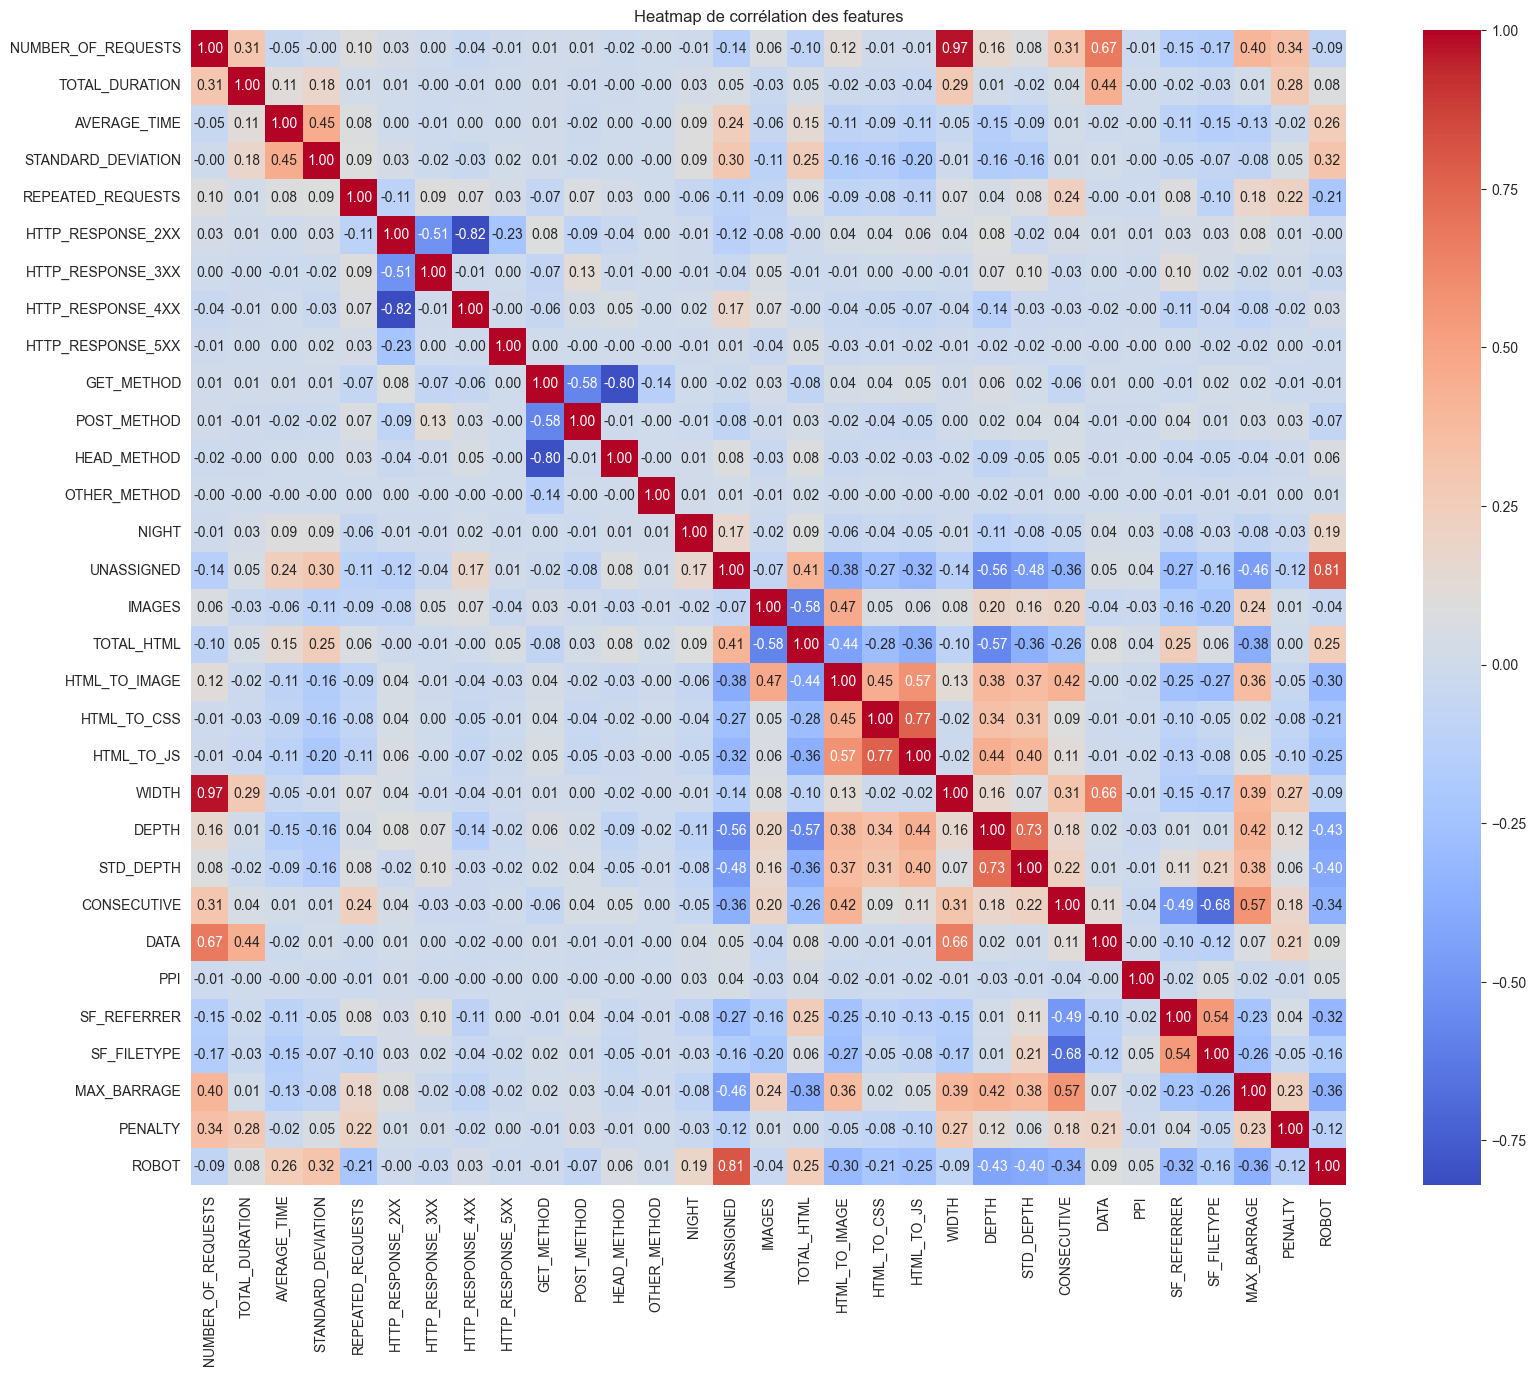

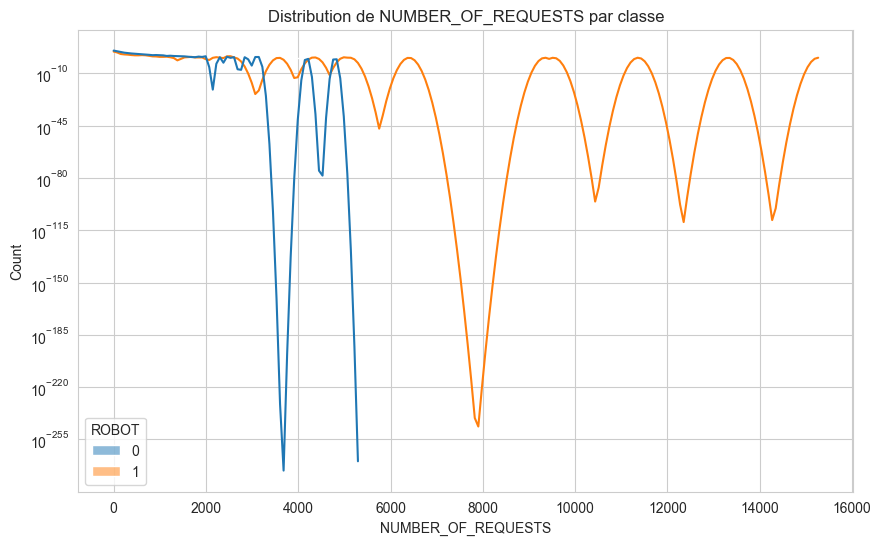

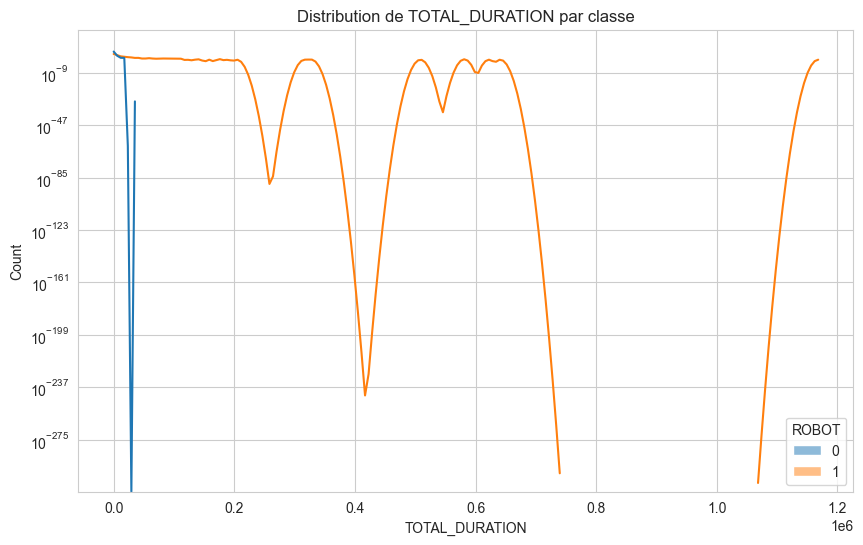

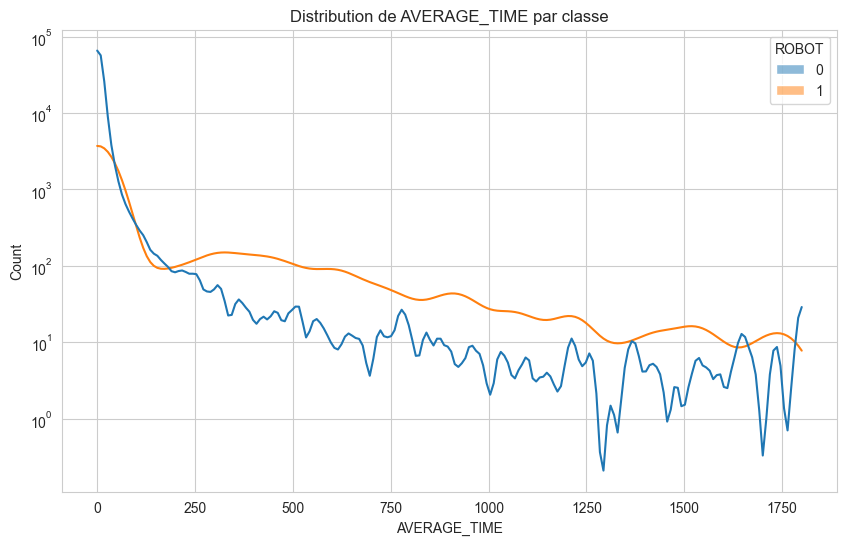

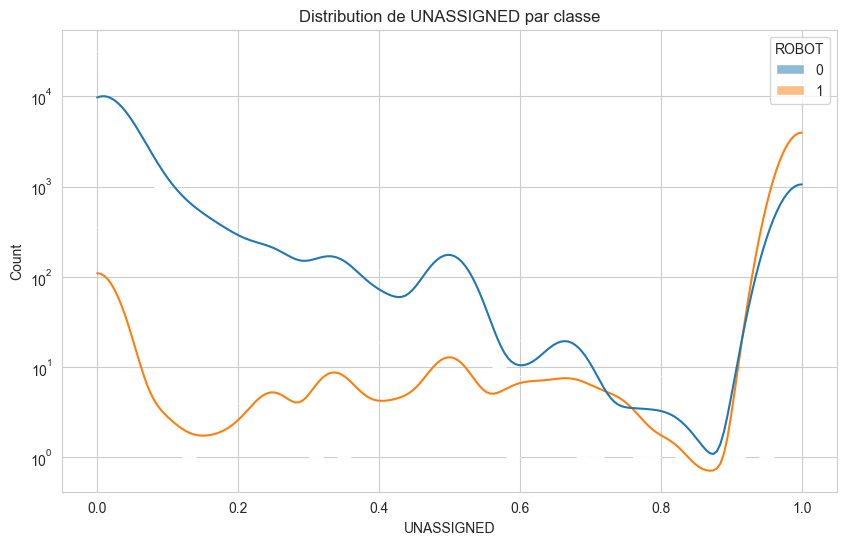

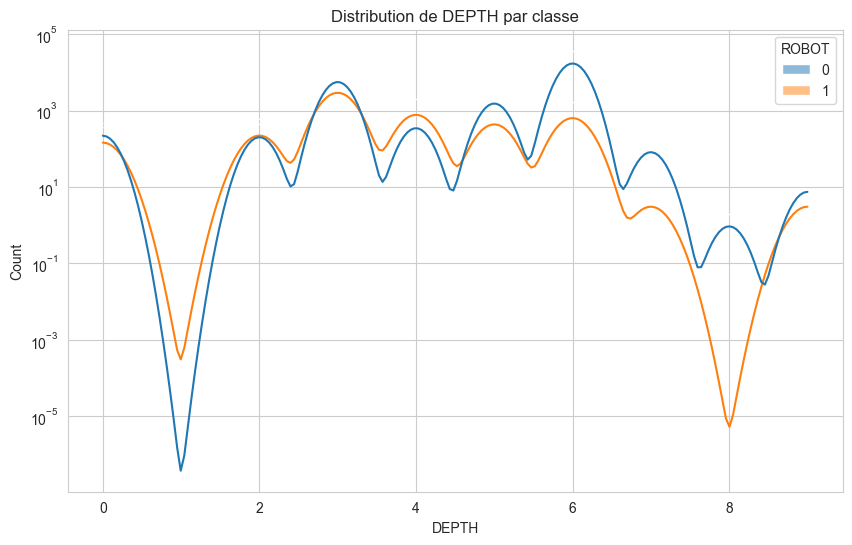

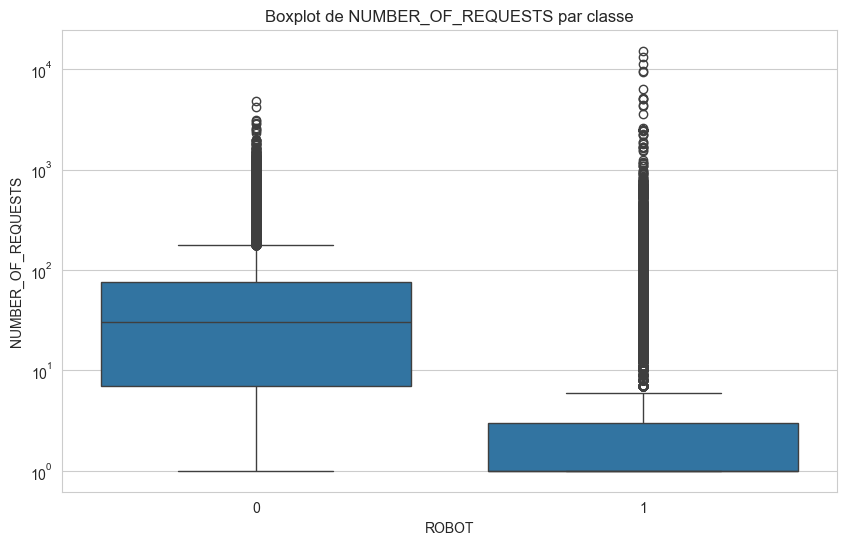

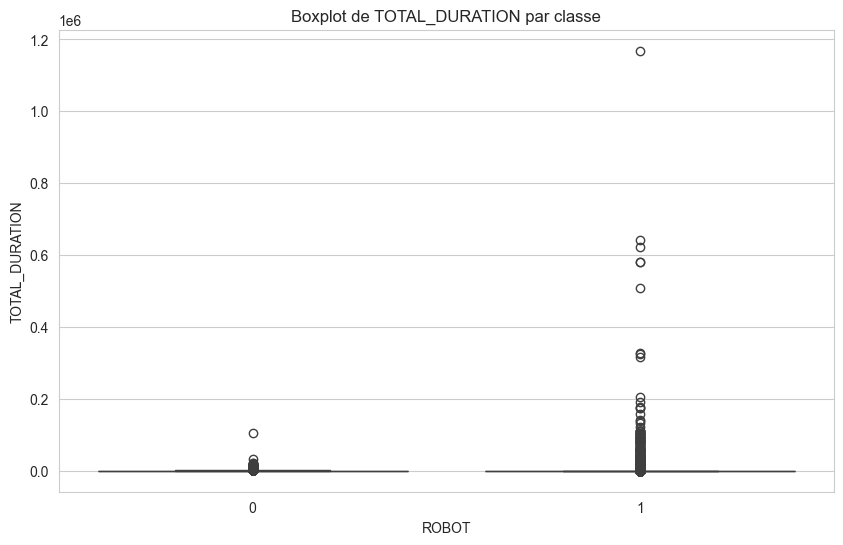

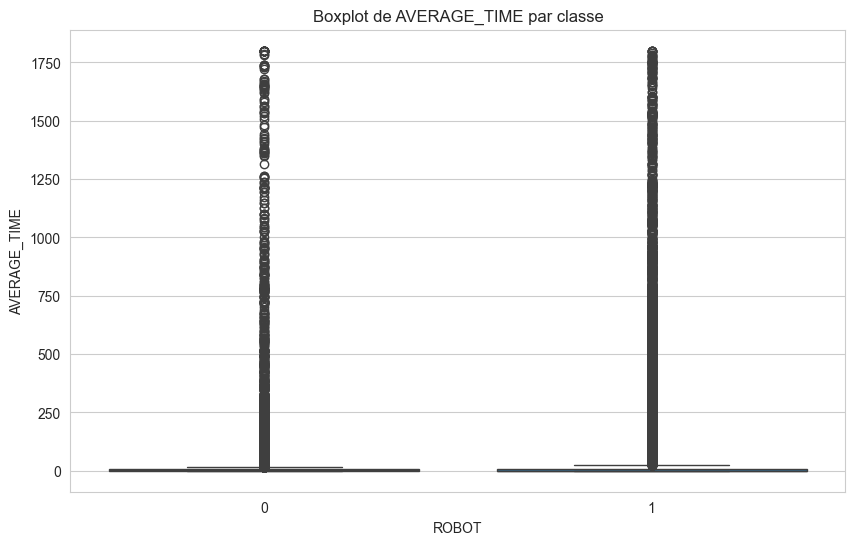

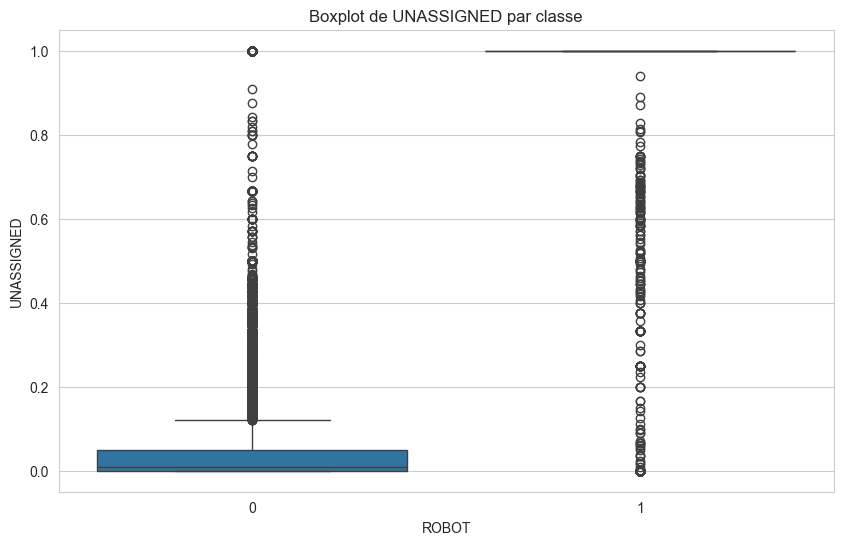

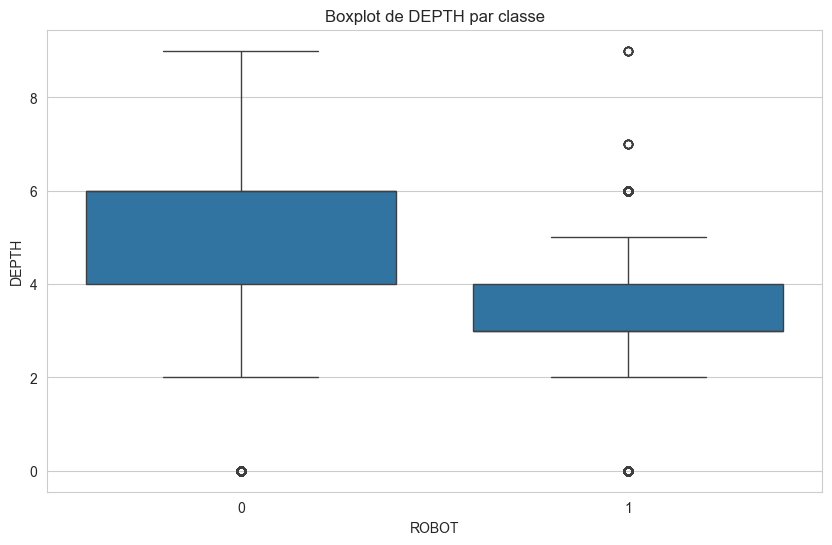

In [74]:
# Etude des corrélations des des outliers

df_numeric = df.drop(columns=['ID'])

# Corrélation entre les variables numériques
plt.figure(figsize=(20, 15))
correlation_matrix = df_numeric.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Heatmap de corrélation des features')
plt.show()

# Distribution de quelques variables semblant intéressantes en fonction de la cible
features_to_plot = ['NUMBER_OF_REQUESTS', 'TOTAL_DURATION', 'AVERAGE_TIME', 'UNASSIGNED', 'DEPTH']

for feature in features_to_plot:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=feature, hue='ROBOT', kde=True, bins=50, log_scale=(False, True))  # log sur y uniquement
    plt.title(f'Distribution de {feature} par classe')
    plt.show()

# Boxplots pour visualiser les outliers
for feature in features_to_plot:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='ROBOT', y=feature)
    plt.title(f'Boxplot de {feature} par classe')
    
    # Transformation log pour éviter erreurs
    if (df[feature] > 0).all():
        plt.yscale('log')
    
    plt.show()

### Commentaire
Le dataset contient 32 colonnes et 67352 instances de sessions. La colonne ID est un identifiant unique qui ne sera pas utile pour la modélisation. C'est la seule donnée de type objet étant donné que les 31 autres features sont de numériques (float64 ou int64)

On peut déjà observer des valeurs manquantes dans certaines features : STANDARD_DEVIATION, SF_REFERRER,   SF_FILETYPE

Les deux classes sont déséquilibrés ce qui va orienter le choix des métriques vers de l'AUC ROC et le F1 Score plutôt que de l'accuracy.

WIDTH semble très redondante en infromation par rapport à NUMBER OF REQUESTS

La feature UNASSIGNED semble très correlée (0.81) à la feature de classification ROBOT et on va donc l'éliminer des features du dataset pour éviter que le modèle s'appuie trop dessus pour prendre de décisions et qu'il n'arrive plus à généraliser sur d'autres types de données.

## Etude des valeurs manquantes


------ Pourcentage de valeurs manquantes par colonne ------

STANDARD_DEVIATION    21.390605
SF_REFERRER           21.390605
SF_FILETYPE           21.390605
dtype: float64


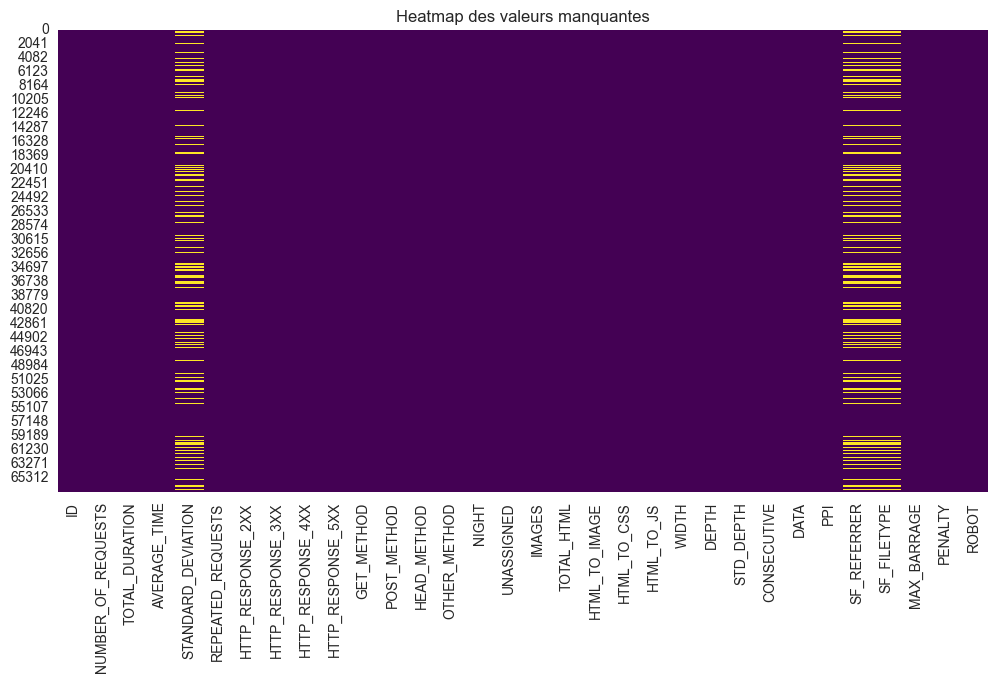

In [75]:
# Etude des valeurs manquantes
print("\n------ Pourcentage de valeurs manquantes par colonne ------\n")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
print(missing_percentage[missing_percentage > 0].sort_values(ascending=False))

# Visualisation des valeurs manquantes
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap des valeurs manquantes')
plt.show()

In [76]:
# Création de la colonne missing_triplet
df['missing_triplet'] = (
    df['STANDARD_DEVIATION'].isna() &
    df['SF_REFERRER'].isna() &
    df['SF_FILETYPE'].isna()
).astype(int)

# Nombre total de robots
nb_bots_total = df['ROBOT'].sum()

# Nombre total d'humains
nb_humans_total = (df['ROBOT'] == 0).sum()

# Nombre de robots qui ont un missing_triplet
nb_bots_with_missing = df[df['missing_triplet'] == 1]['ROBOT'].sum()

# Nombre d'humains qui ont un missing_triplet
nb_humans_with_missing = df[df['missing_triplet'] == 1]['ROBOT'].sum()

# Pourcentage de robots avec un missing triplet
percentage_bots_missing_triplet = nb_bots_with_missing / nb_bots_total * 100

# Pourcentage d'humains avec un missing triplet
percentage_humans_missing_triplet = nb_humans_with_missing / nb_humans_total * 100

print(f"Pourcentage de robots avec missing triplet : {percentage_bots_missing_triplet:.2f}%")
print(f"Pourcentage d'humains avec missing triplet : {percentage_humans_missing_triplet:.2f}%")


Pourcentage de robots avec missing triplet : 59.20%
Pourcentage d'humains avec missing triplet : 14.83%


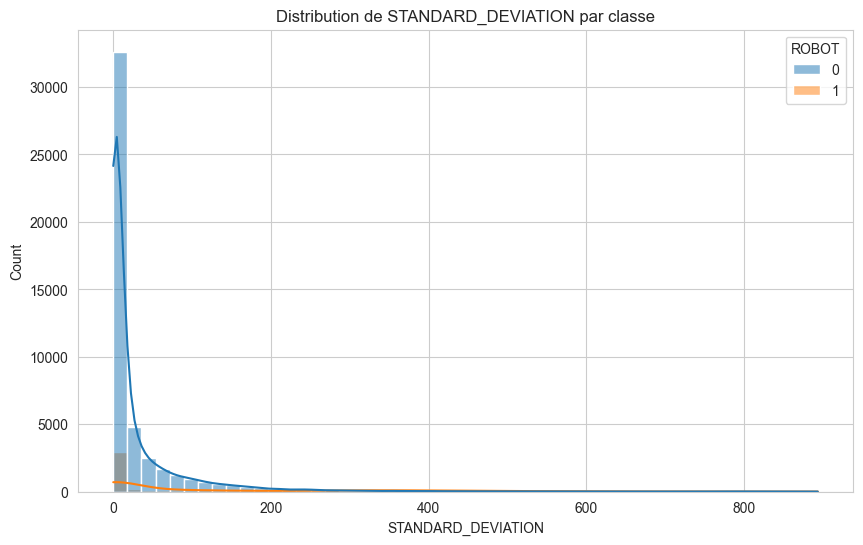

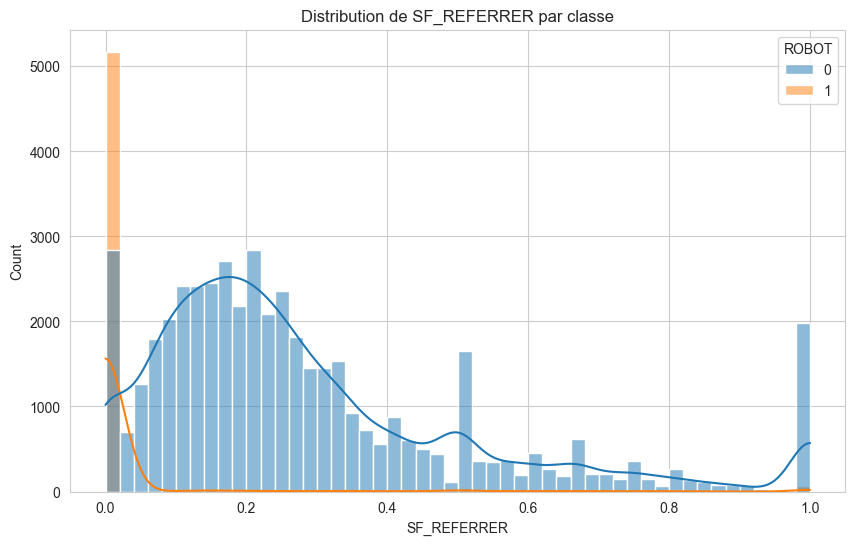

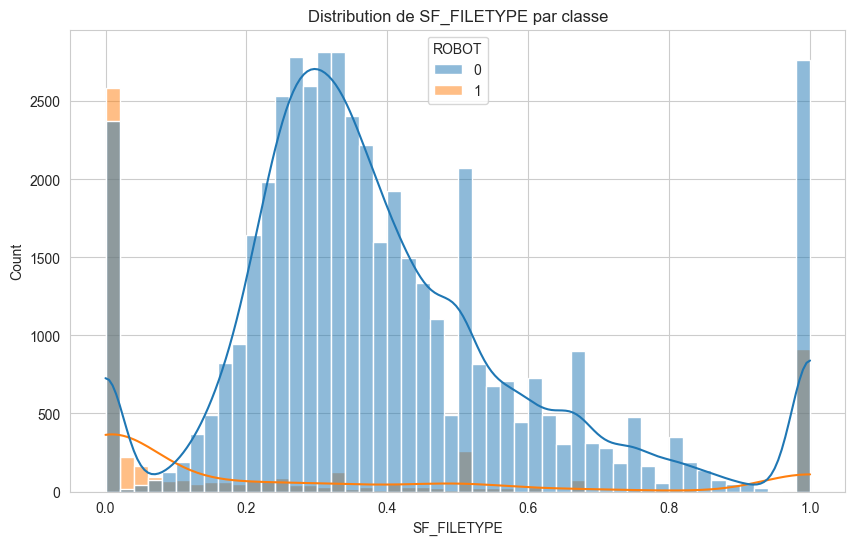

In [77]:
# Distribution des features avec missing values
missing_features = ['STANDARD_DEVIATION','SF_REFERRER','SF_FILETYPE']

for feature in missing_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=feature, hue='ROBOT', kde=True, bins=50) 
    plt.title(f'Distribution de {feature} par classe')
    plt.show()

#### Commentaires sur les valeurs manquantes

Etant donné l'allure de la heatmap des valeurs manquantes, les 3 features (STANDARD_DEVIATION, SF_REFERRER, SF_FILETYPE) semblent former un triplet manquant correlé (les trois colonnes contiennent des valeurs manquantes en simultané)

Pour savoir ci ce triplet manquant est discriminant, on a calculé le pourcentage de bots ayant un triplet de valeur manquantes et le pourcentage d'humain ayant le triplet de valeurs manquantes. On remarque que presque 60% des robots du dataset ont ce triplet manquant contre seulement 15% des humains. 

On va donc pouvoir essayer de créer une feature binaire 'missing_triplet' pour aider le modèle à discriminer les robots des humains.

Pour gérer les valeurs maqnuantes on essayera différentes méthodes :

- drop les colonnes (grosses proportion de missing values et on ne se risque pas à ajouter du bruit)
- imputation par médiane ou moyenne
- imputation par KNN pour essayer d'obtenir des valeurs cohérentes


